In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import joblib



In [2]:
# Load the data
df_players = pd.read_csv('final_data.csv')

# Display the first few rows
df_players.head()



,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.000000,0.000000,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.000000,0.000000,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0
2,/tom-heaton/profil/spieler/34130,Manchester United,Tom Heaton,Goalkeeper,188.0,37.0,4,0.000000,0.000000,0.000000,...,0.616438,0.924658,292,697,84,4,600000,6000000,1,0
3,/lisandro-martinez/profil/spieler/480762,Manchester United,Lisandro Martínez,Defender Centre-Back,175.0,25.0,82,0.028090,0.056180,0.224719,...,0.000000,0.000000,6408,175,22,9,50000000,50000000,2,0
4,/raphael-varane/profil/spieler/164770,Manchester United,Raphaël Varane,Defender Centre-Back,191.0,30.0,63,0.017889,0.017889,0.053667,...,0.000000,0.000000,5031,238,51,21,40000000,80000000,2,0


In [3]:
# Check the shape of the dataset
print(f"Dataset shape: {df_players.shape}")



Dataset shape: (10754, 22)


In [4]:
# Drop unnecessary columns
df_players.drop(columns=['player', 'team', 'name', 'position_encoded'], inplace=True)

# Check and drop duplicates
print(f"Number of duplicates: {df_players.duplicated().sum()}")


Number of duplicates: 8


In [5]:
df_players.drop_duplicates(inplace=True)



In [6]:
# Check the shape after dropping duplicates
print(f"Dataset shape after dropping duplicates: {df_players.shape}")


Dataset shape after dropping duplicates: (10746, 18)


In [7]:

# Check for missing values
print(f"Missing values:\n{df_players.isnull().sum()}")



Missing values:
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
winger                 0
dtype: int64


In [8]:
# Describe the dataset
print(df_players.describe())



             height           age    appearance         goals       assists  \
count  10746.000000  10746.000000  10746.000000  10746.000000  10746.000000   
mean     181.238001     26.045564     36.434115      0.125648      0.087042   
std        6.970505      4.777299     26.517799      0.235648      0.143385   
min      156.000000     15.000000      0.000000      0.000000      0.000000   
25%      176.000000     22.000000     12.000000      0.000000      0.000000   
50%      181.240353     26.000000     35.000000      0.046178      0.040942   
75%      186.000000     29.000000     59.000000      0.172400      0.133226   
max      206.000000     43.000000    107.000000     11.250000      4.000000   

       yellow cards  second yellow cards     red cards  goals conceded  \
count  10746.000000         10746.000000  10746.000000    10746.000000   
mean       0.189898             0.004669      0.006831        0.131753   
std        0.432518             0.025241      0.081173        0.44

In [9]:
# Selecting features for clustering
features = ['appearance', 'goals', 'assists', 'minutes played', 'age', 'award']
X = df_players[features]



In [10]:
# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [11]:
# Applying PCA to reduce dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)



In [12]:
# Finding the best k using the elbow method
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)



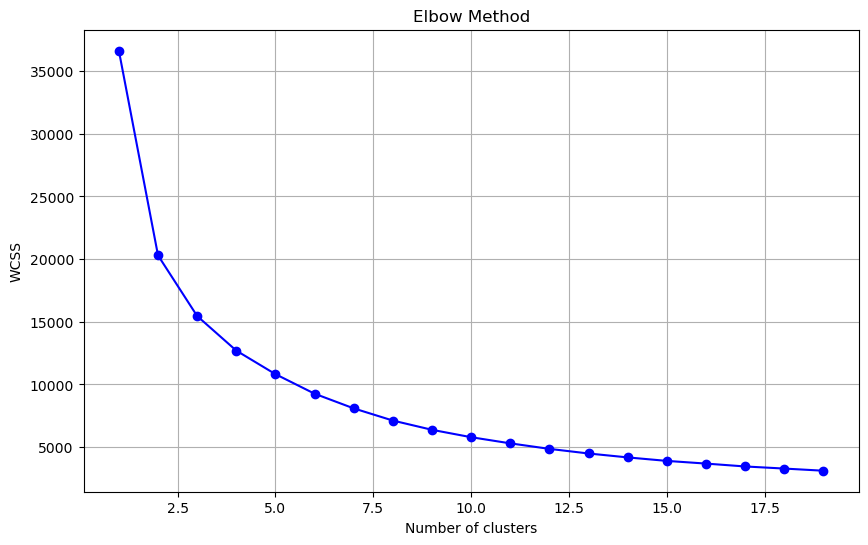

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()



In [14]:
# Based on the elbow method, choose the optimal number of clusters
optimal_clusters = 6  # Replace this with the optimal number based on the elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)



In [15]:
# Fit the model and predict clusters
df_players['cluster'] = kmeans.fit_predict(X_pca)




In [16]:
# Calculate the Silhouette Score
silhouette_avg = silhouette_score(X_pca, df_players['cluster'])
print(f'Silhouette Score after PCA: {silhouette_avg}')


Silhouette Score after PCA: 0.35173195079997693


In [17]:

# Analyzing clusters with respect to 'current_value'
cluster_analysis = df_players.groupby('cluster').agg({
    'current_value': ['mean', 'min', 'max', 'median'],
    'appearance': ['mean'],
    'goals': ['mean'],
    'assists': ['mean'],
    'minutes played': ['mean'],
    'age': ['mean'],
    'award': ['mean']
})

print(cluster_analysis)

        current_value                           appearance     goals  \
                 mean min        max     median       mean      mean   
cluster                                                                
0        9.255923e+05   0   22000000   450000.0  16.018834  0.033645   
1        8.536266e+05   0   15000000   300000.0  10.273315  0.055333   
2        2.629198e+06   0  100000000  1000000.0  45.899413  0.115534   
3        2.625629e+06   0   85000000   650000.0  31.384431  0.440572   
4        6.210017e+06   0   80000000  1800000.0  63.949702  0.081678   
5        1.171687e+07   0  180000000  5000000.0  72.844903  0.233515   

          assists minutes played        age     award  
             mean           mean       mean      mean  
cluster                                                
0        0.021144    1097.247874  31.116672  2.613609  
1        0.036062     614.863513  22.731266  0.419333  
2        0.085283    2988.715068  25.579273  1.286106  
3        0.2947

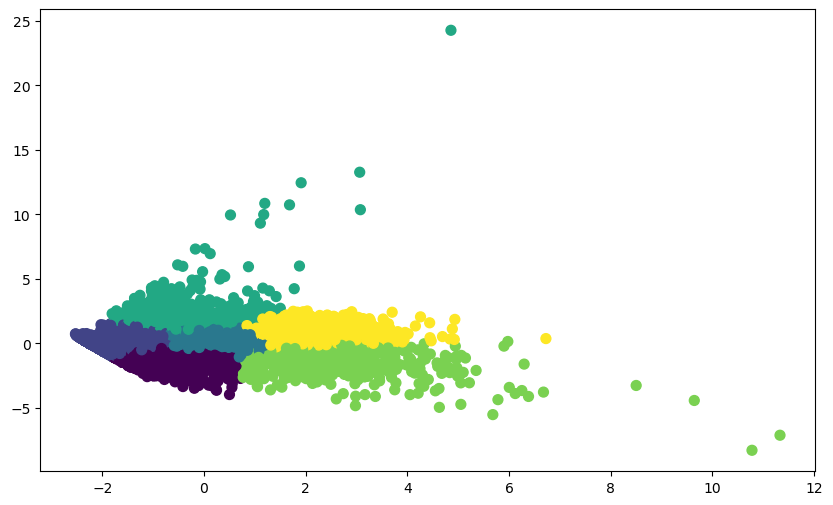

In [18]:
# Visualizing the clusters based on PCA components
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_players['cluster'], s=50, cmap='viridis')

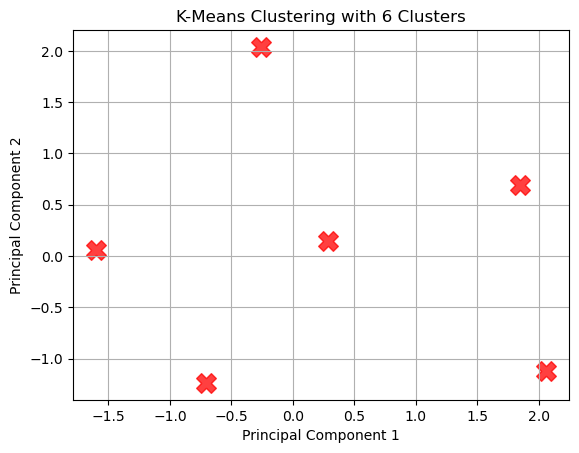

In [19]:
# Plotting cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title(f'K-Means Clustering with {optimal_clusters} Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


In [20]:
# Save the PCA and KMeans models using joblib
joblib.dump(pca, 'pca_model.joblib')
joblib.dump(kmeans, 'kmeans_model.joblib')

['kmeans_model.joblib']